# Continuous structural parameter
Obtaining features and applying adaptive kernel density estimation. For visualization purposes, here we set the number of features $N_f=2$ for all cases.

In [1]:
import numpy as np
from scipy import io
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import manifold

In [30]:
# Load traveltime data and place it an array m by n, where m=200 is the number of 
# simulations and n=722 is the number of traveltime data.
# The m=200 traveltime simulations are obtained from forward geophysical model applied to multiple-point
# geostatistics simulations with channels of varying preferential orientation. The preferential orientation
# of each sample was obtained from a uniform distribution with range [0,180] degrees.
ttdata = np.load('ttdata_cont.npy')
n = np.size(ttdata, axis=1)
nsamps = np.size(ttdata, axis=0)
# load sampled values of orientation.
cp = np.load('cp.npy')

Text(0.5, 1.0, 'PCA_t')

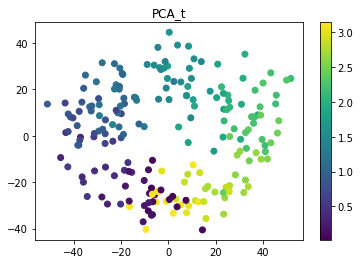

In [36]:
# PCA on traveltimes
dim = 2
mypca = PCA(n_components=dim, random_state=5894)
lowdim = mypca.fit_transform(ttdata)
textmeth = 'PCA_t'
# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
cb = ax.scatter(lowdim[:,0], lowdim[:,1], c=cp[:,0])
fig.colorbar(cb)
ax.set_title(textmeth)

Text(0.5, 1.0, 'MDS_t')

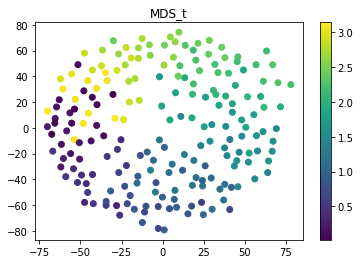

In [9]:
# MDS on traveltimes
dim = 2
mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
lowdim = mymds.fit_transform(ttdata)
textmeth = 'MDS_t'
# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
cb = ax.scatter(lowdim[:,0], lowdim[:,1], c=cp[:,0])
fig.colorbar(cb)
ax.set_title(textmeth)

In [11]:
# Compute oriented averages
nbelec = 19 # number of electrodes in one borehole
orup = np.zeros([nbelec, nbelec])
uprec = np.zeros([nbelec, nbelec])
ordown = np.zeros([nbelec, nbelec])
downrec = np.zeros([nbelec, nbelec])
orav = np.zeros((nsamps, nbelec*2-1)) # substracting the zero-offset reciprocal
for r in range(nsamps):
    ttmat = np.reshape(ttdata[r,:], (38,19))
    for i in range(nbelec):
        for j in range(nbelec-i):
            orup[j,i] = ttmat[j,i+j]
            uprec[j,i] = ttmat[nbelec+i+j,j]
            ordown[j,i] = ttmat[i+j,j]
            downrec[j,i] = ttmat[nbelec+j,i+j]
            #print(nbelec+j+1,i+j+1)
        
    orup[orup==0.] = np.nan
    uprec[uprec==0.] = np.nan
    ordown[ordown==0.] = np.nan
    downrec[downrec==0.] = np.nan
    
    orav[r,0] = np.sum(orup[:,0] + uprec[:,0])/(nbelec*2)
    for i in range(nbelec-1):
        orav[r,i+1] = np.nansum(orup[:,i+1] + uprec[:,i+1])/(nbelec*2-(i+1)*2)
        orav[r,nbelec+i] = np.nansum(ordown[:,i+1] + downrec[:,i+1])/(nbelec*2-(i+1)*2)

Text(0.5, 1.0, 'PCA_a')

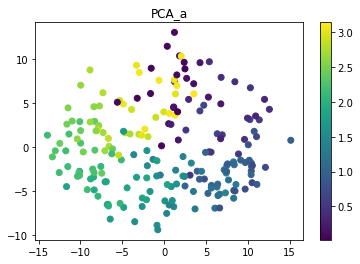

In [12]:
# PCA on oriented averages
dim = 2
mypca = PCA(n_components=dim, random_state=5894)
lowdim = mypca.fit_transform(orav)
textmeth = 'PCA_a'
# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
cb = ax.scatter(lowdim[:,0], lowdim[:,1], c=cp[:,0])
fig.colorbar(cb)
ax.set_title(textmeth)

Text(0.5, 1.0, 'MDS_a')

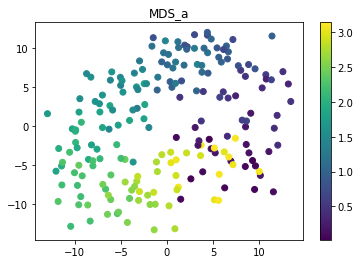

In [14]:
# MDS on oriented averages
dim = 2
mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
lowdim = mymds.fit_transform(orav)
textmeth = 'MDS_a'
# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
cb = ax.scatter(lowdim[:,0], lowdim[:,1], c=cp[:,0])
fig.colorbar(cb)
ax.set_title(textmeth)

In [16]:
# Load (inverted) velocity matrix and place it an array nsamps by n, where nsamps is the number of 
# simulations and n is the number of velocity pixels.
veldata = np.load('veldata_cont.npy')
n = np.size(ttdata, axis=1)
nsamps = np.size(ttdata, axis=0)
# Build arrays (images) of the inverted velocities.
velimag = np.zeros((49,24,nsamps))
for i in range(nsamps):
    velimag[:,:,i] = veldata[i,:].reshape(49,24)

Text(0.5, 1.0, 'MDS_v')

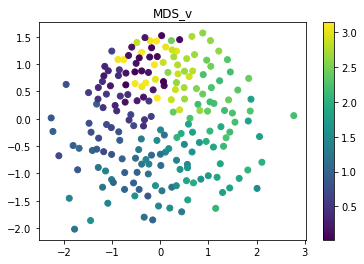

In [20]:
# MDS on (inverted) velocities
dim = 2
mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
lowdim = mymds.fit_transform(veldata)
textmeth = 'MDS_v'
# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
cb = ax.scatter(lowdim[:,0], lowdim[:,1], c=cp[:,0])
fig.colorbar(cb)
ax.set_title(textmeth)

Text(0.5, 1.0, 'MDS_R')

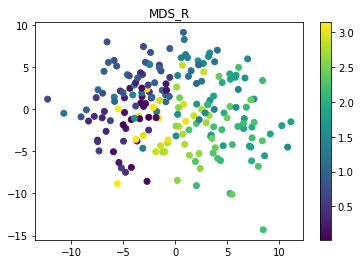

In [31]:
# Radon transform on inverted velocities
from skimage.transform import radon
theta = [0,30,45,60,90,120,135,150]
ntheta = len(theta)
#ntheta= 180
sinogram = np.zeros((70,ntheta,nsamps))
for i in range(nsamps):
    sinogram[:,:,i] = radon(velimag[:,:,i], theta=theta, circle=False)
    
sinogramc = np.zeros((nsamps,70*ntheta))
for i in range(nsamps):
    sinogramc[i,:] = np.reshape(sinogram[:,:,i], (70*ntheta))
    
# MDS on Radon transform of (inverted) velocities
dim = 2
mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
lowdim = mymds.fit_transform(sinogramc)
textmeth = 'MDS_R'
# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
cb = ax.scatter(lowdim[:,0], lowdim[:,1], c=cp[:,0])
fig.colorbar(cb)
ax.set_title(textmeth)

In [37]:
# Set up for adaptive kernel density estimation
from adap_ks_evid_per import adap_ks_evid_per
cpw = 2*cp # symmetry wrapping (to consider the periodic orientation)
fac = np.std(cpw)/np.max(np.std(lowdim, axis=0)) # normalization in each feature axis
# include the structural parameter dimension (to compute the bandwidth in this dimension):
lowdimp = np.column_stack([fac*lowdim,cpw])
dimp = dim + 1
K = 5 # number of clusters for AKDE.

In [38]:
# Cross-validation - compute mean updated probability in true parameter value 
#from ang_diff import ang_diff
updens = np.zeros(nsamps)
upevid = np.zeros(nsamps)
upmean = np.zeros(nsamps)
varobs = np.zeros(nsamps)
for obs_pos in range(nsamps):   
    q = np.zeros([1,dimp])
    q[0,:dim], q[0,dim] = lowdimp[obs_pos,:dim], cpw[obs_pos,0] # set observation position
        
    # take out observation for kernel density estimation
    lowdimpdum = np.concatenate((lowdimp[:obs_pos,:], lowdimp[obs_pos+1:,:]), axis=0)
    obs = q
    updens[obs_pos], upevid[obs_pos], kclus, upmean[obs_pos] = adap_ks_evid_per(lowdimpdum, dimp, K, obs)

upprob = updens/upevid
avprob = np.average(upprob)
logprob = np.average(np.log(upprob))

In [39]:
# Print likelihood score
print(logprob)

-0.27004084051203237
